In [80]:
import matplotlib.pyplot as plt
import numpy as np
import sdf
import glob
import tqdm
import os
import re
from tabulate import tabulate

plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)
import sys

In [81]:
directory = "3run"
save_dir = "plots"

In [82]:
try:
    file_dir = os.path.dirname(os.path.realpath(__file__))
except NameError:
    file_dir = os.getcwd()
DATA_DIR = os.path.join(file_dir, directory)
SAVE_DIR = os.path.join(file_dir, save_dir)

ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
POINTS = len(ALL_FILES)
print(f"Found {POINTS} files")

main_info = {"SDF Files": POINTS}

# Constants
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12
kb = 1.38064852e-23

# Loading Parameters
with open(os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data = myfile.read()


def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None


def find_angle(data):
    angle_reg = re.compile(
        "upper_theta\s+=\s+(\d{0,3})\s{0,3}\*?\s{0,3}pi\s{0,3}\/\s{0,3}(\d{0,3})"
    )
    try:
        a, b = angle_reg.search(data).groups()
    except AttributeError:
        angle_pretty = 0
        angle_rad = 0
        angle_degree = 0
        return angle_pretty, angle_degree, angle_rad

    angle_pretty = f"{a}π/{b}"
    if not a and not b:
        raise ValueError("Angle is not parsed correctly.")
    if not a:
        a = 1
    if not b:
        b = 1
    angle_rad = int(a) * PI / int(b)
    angle_degree = angle_rad * 180 / PI
    angle_degree = round(angle_degree, 1)
    return angle_pretty, angle_degree, angle_rad


raw_data = sdf.read(ALL_FILES[0])

LAMBD = find_value("lambda0") * 1e-6
X, Y = raw_data.Grid_Grid.data
X = X / LAMBD
Y = Y / LAMBD
X_MIN = X.min()
X_MAX = X.max()
Y_MIN = Y.min()
Y_MAX = Y.max()
NX = int(find_value("cells_x"))
NY = int(find_value("cells_y"))
EXTENT = [X_MIN, X_MAX, Y_MIN, Y_MAX]
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("simulation_end"))
DT = find_value("snapshot_freq") * 1e-15
A0 = find_value("a0")
NX = int(find_value("cells_x"))
NY = int(find_value("cells_y"))
angle_pretty, angle_degree, ANGLE = find_angle(data)

main_info["Lambda"] = LAMBD
main_info["Extent"] = EXTENT
main_info["Cells in X"] = NX
main_info["Cells in Y"] = NY
main_info["Laser Time"] = LAS_TIME
main_info["Max Time"] = T_MAX
main_info["Delta T"] = DT
main_info["A0"] = A0
main_info["Angle in Degree"] = angle_degree
main_info["Angle"] = angle_pretty

# Calculating Parameters
omega0 = 2 * PI * c / LAMBD
tau = 2 * PI / omega0
nc = epsilon * m * omega0**2 / e**2
Er = m * omega0 * c / e
LAS_TIME = LAS_TIME * tau
f_max = 1 / (2 * DT)
omega_max = 2 * PI * f_max
omega_max_natural = omega_max / omega0
calculated_info = {
    "Omega0": omega0,
    "Tau": tau,
    "Critical Density": nc,
    "Electric Field": Er,
    "Laser Time": LAS_TIME,
    "Max Resolvable Frequency": f_max,
    "Max Resolvable Omega": omega_max_natural,
}

table_main = tabulate(main_info.items(), headers=["Parameter", "Value"])
table_calculated = tabulate(calculated_info.items(), headers=["Parameter", "Value"])
print(table_main)
print(table_calculated)

Found 501 files
Parameter        Value
---------------  ---------------------------------------
SDF Files        501
Lambda           1e-06
Extent           [-8.0, 1.9999999999999996, -10.0, 10.0]
Cells in X       2000
Cells in Y       4000
Laser Time       4
Max Time         15
Delta T          1.0000000000000001e-16
A0               1.0
Angle in Degree  0
Angle            0
Parameter                        Value
------------------------  ------------
Omega0                     1.88365e+15
Tau                        3.33564e-15
Critical Density           1.11433e+27
Electric Field             3.2107e+12
Laser Time                 1.33426e-14
Max Resolvable Frequency   5e+15
Max Resolvable Omega      16.6782


In [83]:
omega = np.linspace(-omega_max_natural, omega_max_natural, len(ALL_FILES))
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

In [84]:
def plot_field(data_dir, ax, component="y"):
    raw_data = sdf.read(data_dir)
    comp = {
        # "x":raw_data.Electric_Field_Ex,
        "y":raw_data.Electric_Field_Ey,
        # "z":raw_data.Electric_Field_Ez,
    }
    field = comp[component].data.T
    t = raw_data.Header['time']*1e15
    field = field/(field.max()+1e-10)
    ax.imshow(field**2, cmap='jet', origin='lower',
    extent=EXTENT,
    aspect='auto',
    )
    ax.set_xlabel('$x \, [\mu m]$')
    ax.set_ylabel('$y \, [\mu m]$')
    ax.set_title(f't = {t:.1f} fs')


def get_field(id, component):
    raw_data = sdf.read(ALL_FILES[id])
    comp = {
        # "x":raw_data.Electric_Field_Ex,
        "y":raw_data.Electric_Field_Ey,
        # "z":raw_data.Electric_Field_Ez,
    }
    field = comp[component].data.T
    return field

In [85]:
NX*=0.2
NY*=0.2

In [86]:
def x_position_to_node(x):
    return int((x - X_MIN)/(X_MAX - X_MIN)*NX)

def y_position_to_node(y):
    return int((y - Y_MIN)/(Y_MAX - Y_MIN)*NY)

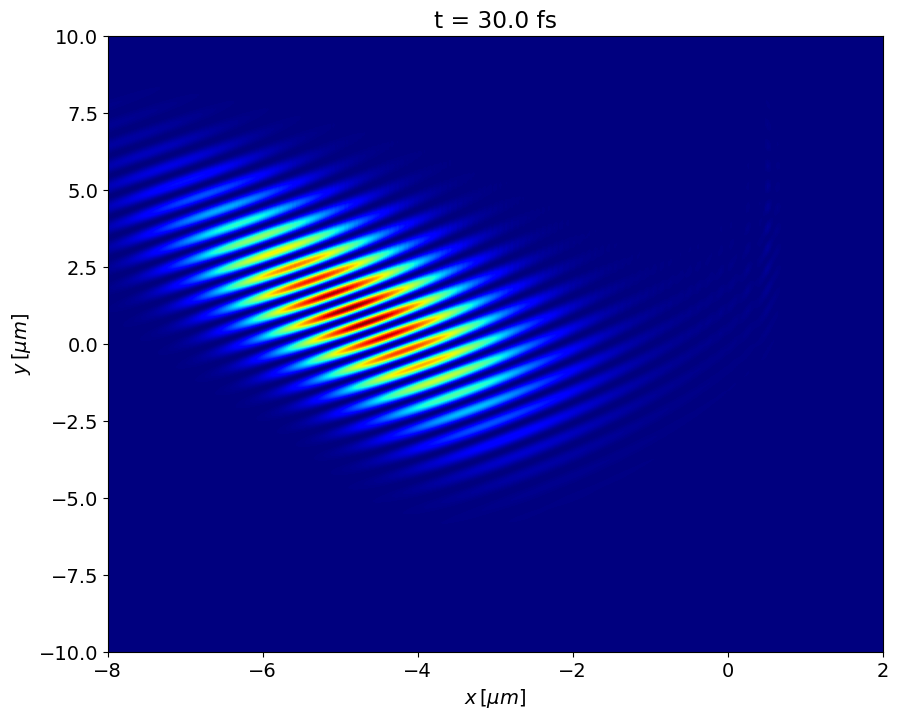

In [87]:
plot_field(ALL_FILES[300], plt.gca(), component="y")

In [88]:
T = np.linspace(0, T_MAX, len(ALL_FILES))

def get_image_name(name):
    if name is not None:
        fig_name = os.path.join(SAVE_DIR, name)
        if "." not in fig_name:
            fig_name += ".png"
    else:
        fig_name = None
    return fig_name


def x_position_to_node(x):
    return int((x - X_MIN)/(X_MAX - X_MIN)*NX)

def y_position_to_node(y):
    return int((y - Y_MIN)/(Y_MAX - Y_MIN)*NY)

def get_y_for_x(x):
    return x*np.tan(ANGLE)

In [89]:
x_b = -6
y_b = -get_y_for_x(x_b)
x_a = -4
y_a = get_y_for_x(x_a)
x_c = -2
y_c = get_y_for_x(x_c)

x_b_node = x_position_to_node(x_b)
y_b_node = y_position_to_node(y_b)
x_a_node = x_position_to_node(x_a)
y_a_node = y_position_to_node(y_a)
x_c_node = x_position_to_node(x_c)
y_c_node = y_position_to_node(y_c)
point_a = (x_a_node, y_a_node)
point_b = (x_b_node, y_b_node)
point_c = (x_c_node, y_c_node)

print(f"Point A: {point_a}")
print(f"Point B: {point_b}")
print(f"Point C: {point_c}")

Point A: (160, 400)
Point B: (80, 400)
Point C: (240, 400)


In [90]:
point1 = point_b
point2 = point_a
points3 = point_c

Ex1 = np.zeros(POINTS)
Ex2 = np.zeros(POINTS)
Ex3 = np.zeros(POINTS)
Ey1 = np.zeros(POINTS)
Ey2 = np.zeros(POINTS)
Ey3 = np.zeros(POINTS)
Ez1 = np.zeros(POINTS)
Ez2 = np.zeros(POINTS)
Ez3 = np.zeros(POINTS)


for i in tqdm.tqdm(
    range(POINTS),
    desc="Calculating fields",
    unit="files",
    file=sys.stdout,
):
    raw_data = sdf.read(ALL_FILES[i])
    Ex = raw_data.Electric_Field_Ex.data
    Ey = raw_data.Electric_Field_Ey.data
    Ez = raw_data.Electric_Field_Ez.data

    Ex1[i] = Ex[point1]
    Ex2[i] = Ex[point2]
    Ex3[i] = Ex[points3]

    Ey1[i] = Ey[point1]
    Ey2[i] = Ey[point2]
    Ey3[i] = Ey[points3]

    Ez1[i] = Ez[point1]
    Ez2[i] = Ez[point2]
    Ez3[i] = Ez[points3]

Calculating fields: 100%|██████████| 501/501 [00:06<00:00, 81.47files/s]


In [91]:
def plot_one_fft(
    ax,
    E,
    component="y",
    title="",
    plot_lines=True,
):
    fft = np.fft.fft(E)
    fft = np.fft.fftshift(fft)
    fft = np.abs(fft)
    fft = fft / (fft.max() + 1e-10)
    ax.plot(omega, fft**2, label=f"$E_{component}$")
    ax.set_yscale("log")
    ax.set_xlim(
        0,
    )
    ax.set_xlabel("$\omega$")
    ax.set_ylabel("$\mathcal{|E|}^2$")
    ax.set_title(title, fontdict={"fontsize": 12})
    ax.legend()
    
    xticks = np.arange(1, int(omega_max_natural) + 3, 2)
    ax.set_xticks(xticks)

    if plot_lines:
        for x in xticks:
            ax.axvline(x, color="k", alpha=0.7, linewidth=0.5)

def plot_ffts_func(save_fig=True, prefix="", show=True):
    if save_fig:
        fig_name_x = f"{prefix}_Ex_fft"
        fig_name_y = f"{prefix}_Ey_fft"
        fig_name_z = f"{prefix}_Ez_fft"
    else:
        fig_name_x = None
        fig_name_y = None
        fig_name_z = None

    if Ez1.max() > 0:
        fig, axes = plt.subplots(3, 1, figsize=(5, 15))
        Es = [Ez1, Ez2, Ez3]
        titles = [
            f"$E_z$ at ({point1[0]}, {point1[1]})",
            f"$E_z$ at ({point2[0]}, {point2[1]})",
            f"$E_z$ at ({points3[0]}, {points3[1]})",
        ]
        for i, ax in enumerate(axes):
            plot_one_fft(
                ax,
                Es[i],
                component="z",
                title=titles[i],
            )
        fig_name = get_image_name(fig_name_z)
        print(f"Figure name for z fft is {fig_name}")
        if fig_name:
            fig.savefig(fig_name)
        if show:
            plt.show()
        plt.close()
    else:
        print("Ez is zero. Skipping plot.")

    if Ex1.max() > 0:
        fig, axes = plt.subplots(3, 1, figsize=(5, 15))
        Es = [Ex1, Ex2, Ex3]
        titles = [
            f"$E_x$ at ({point1[0]}, {point1[1]})",
            f"$E_x$ at ({point2[0]}, {point2[1]})",
            f"$E_x$ at ({points3[0]}, {points3[1]})",
        ]
        for i, ax in enumerate(axes):
            plot_one_fft(
                ax,
                Es[i],
                component="x",
                title=titles[i],
            )
        fig_name = get_image_name(fig_name_x)
        print(f"Figure name for x fft is {fig_name}")
        if fig_name:
            fig.savefig(fig_name)
        if show:
            plt.show()
        plt.close()
    else:
        print("Ex is zero. Skipping plot.")

    if Ey1.max() > 0:
        fig, axes = plt.subplots(3, 1, figsize=(5, 15))
        Es = [Ey1, Ey2, Ey3]
        titles = [
            f"$E_y$ at ({point1[0]}, {point1[1]})",
            f"$E_y$ at ({point2[0]}, {point2[1]})",
            f"$E_y$ at ({points3[0]}, {points3[1]})",
        ]
        for i, ax in enumerate(axes):
            plot_one_fft(
                ax,
                Es[i],
                component="y",
                title=titles[i],
            )
        fig_name = get_image_name(fig_name_y)
        print(f"Figure name for y fft is {fig_name}")
        if fig_name:
            fig.savefig(fig_name)
        if show:
            plt.show()
        plt.close()
    else:
        print("Ey is zero. Skipping plot.")

Ez is zero. Skipping plot.
Figure name for x fft is None


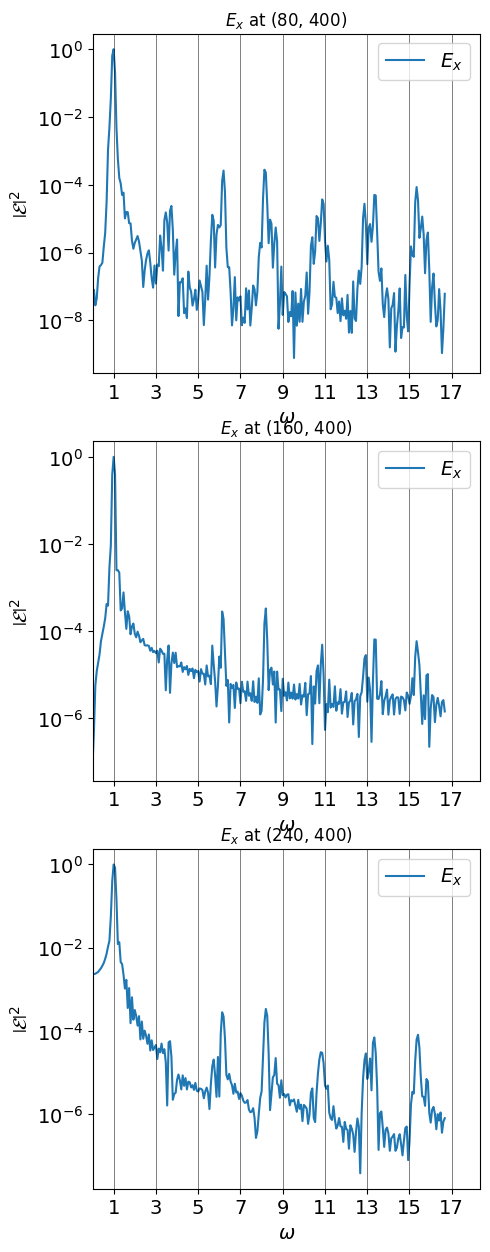

Figure name for y fft is None


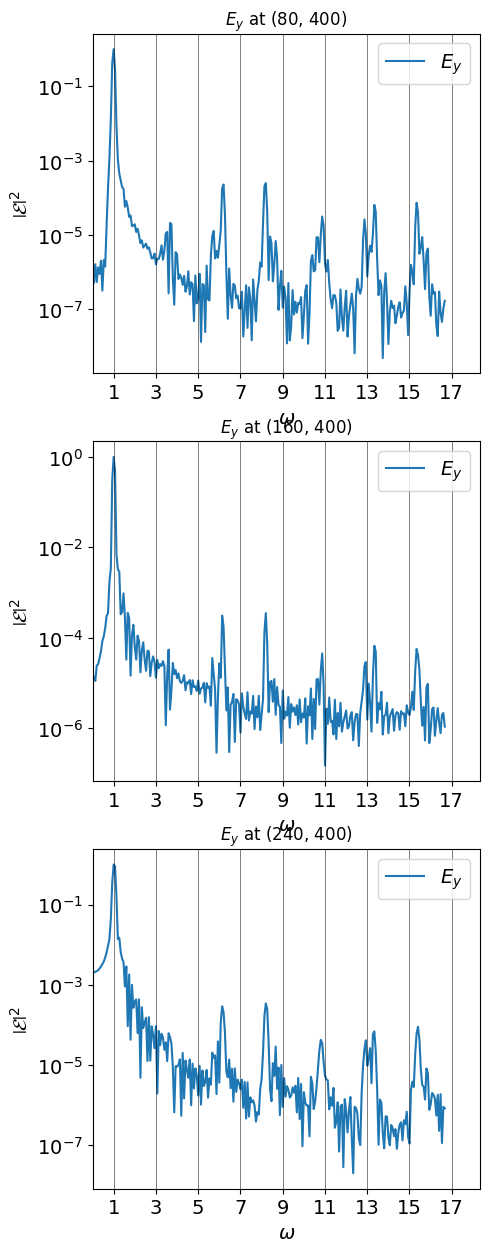

In [92]:
save_fig = False
prefix = None
plot_ffts_func(save_fig=save_fig, prefix=prefix, show=True)